In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# from vae_earlystopping import EarlyStopping
from torch.utils.data import  DataLoader, Dataset
# from model_vae import CVAE, cvae_loss
# from vae_earlystopping import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'vae_earlystopping'

In [4]:
x_data = np.load('./data/metal.npy')
c_data=  np.load('./data/reaction.npy')

In [5]:
# 페로브스카이트 빼기
x_data = x_data[:,1:]
x_data.shape

(5908, 23)

### 데이터 나누기 -> 다 섞는다

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4, random_state = 21)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5, random_state = 21)
print(x_train.shape,x_val.shape,x_test.shape)

(3544, 23) (1182, 23) (1182, 23)


## StandardScaler에서 MinMaxScaler로 바꾸기

In [7]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
c_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_train)
c_train = c_scaler.fit_transform(c_train)
x_data = [x_val,x_test]
c_data = [c_val,c_test]
x_val, x_test = [x_scaler.transform(x) for x in x_data]
c_val,c_test = [c_scaler.transform(c) for c in c_data]

In [8]:
x_train,x_val,x_test = [torch.tensor(x,dtype = torch.float32) for x in [x_train,x_val,x_test]]
c_train,c_val,c_test = [torch.tensor(x,dtype = torch.float32) for x in [c_train,c_val,c_test]]

## 텐서로 바꾸기

In [9]:
from torch.utils.data import DataLoader, TensorDataset
train_data = [x_train,c_train]
val_data =  [x_val,c_val]
test_data =  [x_test,c_test]
## 텐서로 바꾸기
train_data = TensorDataset(*train_data)
val_data = TensorDataset(*val_data)
test_data = TensorDataset(*test_data)

In [10]:
type(train_data)

torch.utils.data.dataset.TensorDataset

## batch사이즈 정하기

In [11]:
batch_size = 64
shuffle_data = [train_data, val_data,test_data]
train_loader,val_loader,test_loader = [DataLoader(x, batch_size = batch_size, shuffle = False) for x in shuffle_data]
type(train_loader)


torch.utils.data.dataloader.DataLoader

In [12]:
for i, (x, c) in enumerate(train_loader):
    print(f'[{i+1}번째 batch] [{len(x)},{len(c)}]', end=' ')


[1번째 batch] [64,64] [2번째 batch] [64,64] [3번째 batch] [64,64] [4번째 batch] [64,64] [5번째 batch] [64,64] [6번째 batch] [64,64] [7번째 batch] [64,64] [8번째 batch] [64,64] [9번째 batch] [64,64] [10번째 batch] [64,64] [11번째 batch] [64,64] [12번째 batch] [64,64] [13번째 batch] [64,64] [14번째 batch] [64,64] [15번째 batch] [64,64] [16번째 batch] [64,64] [17번째 batch] [64,64] [18번째 batch] [64,64] [19번째 batch] [64,64] [20번째 batch] [64,64] [21번째 batch] [64,64] [22번째 batch] [64,64] [23번째 batch] [64,64] [24번째 batch] [64,64] [25번째 batch] [64,64] [26번째 batch] [64,64] [27번째 batch] [64,64] [28번째 batch] [64,64] [29번째 batch] [64,64] [30번째 batch] [64,64] [31번째 batch] [64,64] [32번째 batch] [64,64] [33번째 batch] [64,64] [34번째 batch] [64,64] [35번째 batch] [64,64] [36번째 batch] [64,64] [37번째 batch] [64,64] [38번째 batch] [64,64] [39번째 batch] [64,64] [40번째 batch] [64,64] [41번째 batch] [64,64] [42번째 batch] [64,64] [43번째 batch] [64,64] [44번째 batch] [64,64] [45번째 batch] [64,64] [46번째 batch] [64,64] [47번째 batch] [64,64] [48번째 batch] [64,64] [

### dim 정하기

In [13]:
x_dim = x_train.shape[1] # 23
c_dim = c_train.shape[1] # 9
z_dim = 16

In [14]:
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

## model training Process

In [ ]:
epochs = 200
early = EarlyStopping(patience = 30, min_delta = 1e-4)
train_losses = []
val_losses = []
for epoch in range(1,epochs+1):
    model.train()
    train_total_loss = 0.0
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        x_hat, mu,logvar = model(x,c)
        loss,recon,kl = cvae_loss(x_hat,x,mu,logvar,beta=0.01)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss = loss.item()
    avg_train_loss = total_train_loss/len(train_loader)
    #---점검
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)
            v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            v_loss,_,_ = cvae_loss(v_x_hat,v_x,v_mu,v_logvar,beta = 0.01)
            total_val_loss += v_loss.item()
    avg_val_loss = total_val_loss/len(val_loader)  
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    if epoch % 20 == 0 or epoch == 1:
        print(f'[{epoch}/{epochs}] train_loss:{avg_train_loss:.4f}, val_loss:{avg_val_loss:.4f}')
    stop = early.step(avg_val_loss,model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch
    if stop:
        print(f"Early stopping at epoch {epoch}. Best epoch:{best_epoch}, Best val loss: {early.best:.6f}")
        break
    
        

[1/200] train_loss:0.0005, val_loss:0.0272
[20/200] train_loss:0.0001, val_loss:0.0048
[40/200] train_loss:0.0001, val_loss:0.0047
[60/200] train_loss:0.0001, val_loss:0.0045
[80/200] train_loss:0.0000, val_loss:0.0044
[100/200] train_loss:0.0000, val_loss:0.0043
[120/200] train_loss:0.0000, val_loss:0.0042
[140/200] train_loss:0.0000, val_loss:0.0041
[160/200] train_loss:0.0000, val_loss:0.0039


## k는 명칭이고, v는

In [ ]:
for k,v in model.state_dict().items():
    print(k)

enc1.weight
enc1.bias
enc2.weight
enc2.bias
mu.weight
mu.bias
logvar.weight
logvar.bias
dec1.weight
dec1.bias
dec2.weight
dec2.bias
out.weight
out.bias


In [ ]:
len(val_losses)

148

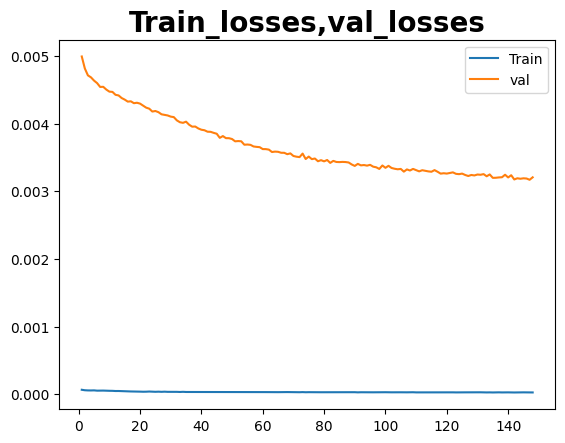

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_array=  np.arange(1, len(val_losses)+1)
plt.plot(x_array,train_losses,label = 'Train')
plt.plot(x_array,val_losses,label = 'val')
plt.legend()
plt.title('Train_losses,val_losses', fontsize = 20, fontweight = 'bold')
plt.show()

In [ ]:
for k,v in early.best_state.items():
    print(k)

enc1.weight
enc1.bias
enc2.weight
enc2.bias
mu.weight
mu.bias
logvar.weight
logvar.bias
dec1.weight
dec1.bias
dec2.weight
dec2.bias
out.weight
out.bias


In [ ]:
model.load_state_dict(early.best_state)
model= model.to(device)
model.eval()
for x_test,c_test in test_loader:
    x_test = x_test.to(device)
    c_test = c_test.to(device)
    x_hat_test,test_mu,test_logvar = model(x_test,c_test)
    test_loss,_,_ = cvae_loss(x_hat_test,x_test,test_mu,test_logvar)

In [ ]:
x_true_test_np = x_test.detach().cpu().numpy()
x_hat_test_np = x_hat_test.detach().cpu().numpy()
x_true_test = x_scaler.inverse_transform(x_true_test_np)
x_hat_test = x_scaler.inverse_transform(x_hat_test_np)

In [ ]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,2:25].columns

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse},r2: {r2}')

rmse: 1.051987873442637,r2: 0.6334744691848755


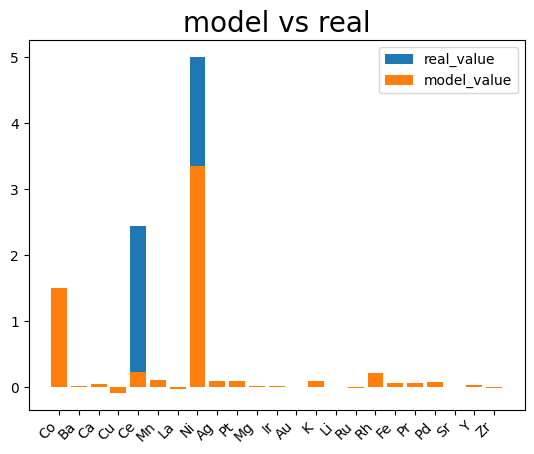

In [ ]:
plt.bar(metal_columns, x_true_test[4],label = 'real_value')
plt.bar(metal_columns,x_hat_test[4],label = 'model_value')
plt.xticks(rotation=45,ha='right')
plt.title(f'model vs real',fontsize = 20)
plt.legend()
plt.show()